### 8.6 토픽 모델링- 20 Newsgroup 토픽 모델링
20개 중 8개의 주제 데이터 로드 및 count기반 피처 벡터화. LDA는 Count 기반 Vectorizer만 적용한다.

In [3]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation#lDA

# 모터사이클, 야구, 그래픽스, 윈도우즈, 중동, 기독교, 의학, 우주 주제를 추출. 
cats = ['rec.motorcycles', 'rec.sport.baseball', 'comp.graphics', 'comp.windows.x',
        'talk.politics.mideast', 'soc.religion.christian', 'sci.electronics', 'sci.med'  ]

# 위에서 cats 변수로 기재된 category만 추출. featch_20newsgroups( )의 categories에 cats 입력
news_df= fetch_20newsgroups(subset='all',remove=('headers', 'footers', 'quotes'), 
                            categories=cats, random_state=0)

#LDA는 Count 기반의 Vectorizer만 적용합니다.  
count_vect = CountVectorizer(max_df=0.95, max_features=1000, min_df=2, stop_words='english', ngram_range=(1,2))
feat_vect = count_vect.fit_transform(news_df.data)
print('CountVectorizer Shape:', feat_vect.shape)

CountVectorizer Shape: (7862, 1000)


In [4]:
lda = LatentDirichletAllocation(n_components=8, random_state=0)
lda.fit(feat_vect)

LatentDirichletAllocation(n_components=8, random_state=0)

#### 각 토픽 모델링 주제별 단어들과의 연관도 확인
- lda객체의 components_속성은 주제별로 개별 단어들의 연관도 정규화 숫자가 들어있다.
- shape은 주제 개수 x 피처 단어 개수
- components_에 들어있는 숫자값은 각 주제별로 단어가 나타난 횟수를 정규화 하여 나타냄
- 숫자가 클 수록 토픽에서 단어가 차지하는 비중이 높다.

In [5]:
print(lda.components_.shape)
lda.components_

(8, 1000)


array([[3.60992018e+01, 1.35626798e+02, 2.15751867e+01, ...,
        3.02911688e+01, 8.66830093e+01, 6.79285199e+01],
       [1.25199920e-01, 1.44401815e+01, 1.25045596e-01, ...,
        1.81506995e+02, 1.25097844e-01, 9.39593286e+01],
       [3.34762663e+02, 1.25176265e-01, 1.46743299e+02, ...,
        1.25105772e-01, 3.63689741e+01, 1.25025218e-01],
       ...,
       [3.60204965e+01, 2.08640688e+01, 4.29606813e+00, ...,
        1.45056650e+01, 8.33854413e+00, 1.55690009e+01],
       [1.25128711e-01, 1.25247756e-01, 1.25005143e-01, ...,
        9.17278769e+01, 1.25177668e-01, 3.74575887e+01],
       [5.49258690e+01, 4.47009532e+00, 9.88524814e+00, ...,
        4.87048440e+01, 1.25034678e-01, 1.25074632e-01]])

In [11]:
def display_topics(model, feature_names, no_top_words):
    for topic_index, topic in enumerate(model.components_):
        print('Topic #',topic_index)

        # components_ array에서 가장 값이 큰 순으로 정렬했을 때, 그 값의 array index를 반환. 
        topic_word_indexes = topic.argsort()[::-1]
        top_indexes=topic_word_indexes[:no_top_words]
        
        # top_indexes대상인 index별로 feature_names에 해당하는 word feature 추출 후 join으로 concat
        feature_concat = ' '.join([feature_names[i] for i in top_indexes])                
        print(feature_concat)

# CountVectorizer객체내의 전체 word들의 명칭을 get_features_names( )를 통해 추출
feature_names = count_vect.get_feature_names_out()#최신 버전은 이거

# Topic별 가장 연관도가 높은 word를 15개만 추출
display_topics(lda, feature_names, 15)

Topic # 0
year 10 game medical health team 12 20 disease cancer 1993 games years patients good
Topic # 1
don just like know people said think time ve didn right going say ll way
Topic # 2
image file jpeg program gif images output format files color entry 00 use bit 03
Topic # 3
like know don think use does just good time book read information people used post
Topic # 4
armenian israel armenians jews turkish people israeli jewish government war dos dos turkey arab armenia 000
Topic # 5
edu com available graphics ftp data pub motif mail widget software mit information version sun
Topic # 6
god people jesus church believe christ does christian say think christians bible faith sin life
Topic # 7
use dos thanks windows using window does display help like problem server need know run


### 개별 문서별 토픽 분포 확인
lda객체의 transform()을 수행하면 개별 문서별 토픽 분포를 반환함

In [12]:
doc_topics=lda.transform(feat_vect)
print(doc_topics.shape)
print(doc_topics[:3])

(7862, 8)
[[0.01389701 0.01394362 0.01389104 0.48221844 0.01397882 0.01389205
  0.01393501 0.43424401]
 [0.27750436 0.18151826 0.0021208  0.53037189 0.00212129 0.00212102
  0.00212113 0.00212125]
 [0.00544459 0.22166575 0.00544539 0.00544528 0.00544039 0.00544168
  0.00544182 0.74567512]]


### 개별 문서별 토픽 분포도 출력
- 20newsgroup으로 만들어진 문서명을 출력
- fetch_20newsgroups()으로 만들어진 데이터의 filename속성은 모든 문서의 문서명을 가지고 이싿.
- filename속성은 절대 디렉토리를 가지는 문서명을 가지고 있으므로 '\'로 분할하여 맨 마지막 부터 파일면으로 가져옴

In [19]:
def get_filename_list(newsdata):
    filename_list=[]
    for file in newsdata.filenames:
        # print(file)
        filename_temp=file.split('\\')[-2:]
        filename='.'.join(filename_temp)
        filename_list.append(filename)

    return filename_list

filename_list=get_filename_list(news_df)
print("filename 개수:", len(filename_list),"filename list 10개만",filename_list[:10])

filename 개수: 7862 filename list 10개만 ['soc.religion.christian.20630', 'sci.med.59422', 'comp.graphics.38765', 'comp.graphics.38810', 'sci.med.59449', 'comp.graphics.38461', 'comp.windows.x.66959', 'rec.motorcycles.104487', 'sci.electronics.53875', 'sci.electronics.53617']


- dataframe으로 생성하여 문서별 토픽 분포도 확인

In [22]:
import pandas as pd

topic_names=['Topic #'+str(i) for i in range(0,8)]
doc_topic_df=pd.DataFrame(data=doc_topics, columns=topic_names, index=filename_list)
doc_topic_df.head()
# doc_topic_df.shape

,Topic #0,Topic #1,Topic #2,Topic #3,Topic #4,Topic #5,Topic #6,Topic #7
soc.religion.christian.20630,0.013897,0.013944,0.013891,0.482218,0.013979,0.013892,0.013935,0.434244
sci.med.59422,0.277504,0.181518,0.002121,0.530372,0.002121,0.002121,0.002121,0.002121
comp.graphics.38765,0.005445,0.221666,0.005445,0.005445,0.005440,0.005442,0.005442,0.745675
comp.graphics.38810,0.005439,0.005441,0.005449,0.578959,0.005440,0.388387,0.005442,0.005442
sci.med.59449,0.006584,0.552000,0.006587,0.408485,0.006585,0.006585,0.006588,0.006585


### 8.7 문서 군집화 소개와 실습(opinion review 데이터 세트)

In [25]:
import pandas as pd
import glob, os
import warnings 
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', 700)
#r- 윈도우는 \\로 해야하는데 그걸 방지해줌
path = r"C:\Users\a0103\OneDrive\바탕 화면\데이터분석 스터디\파이썬 머신러닝 완벽 가이드\OpinosisDataset1.0\topics"
# path로 지정한 디렉터리 밑에 있는 모든 .data 파일들의 파일명을 리스트로 취합
all_files = glob.glob(os.path.join(path, "*.data"))    
filename_list = []
opinion_text = []

# 개별 파일들의 파일명은 filename_list 리스트로 취합, 
# 개별 파일들의 파일 내용은 DataFrame 로딩 후 다시 string으로 변환하여 opinion_text 리스트로 취함 
for file_ in all_files:
    # 개별 파일을 읽어서 DataFrame으로 생성 
    df = pd.read_table(file_,index_col=None, header=0,encoding='latin1')
    # 절대경로로 주어진 file 명을 가공. 만일 Linux에서 수행시에는 아래 \\를 / 변경. 
    # 맨 마지막 .data 확장자도 제거
    filename_ = file_.split('\\')[-1]
    filename = filename_.split('.')[0]

    # 파일명 리스트와 파일 내용 리스트에 파일명과 파일 내용을 추가. 
    filename_list.append(filename)
    opinion_text.append(df.to_string())

# 파일명 리스트와 파일 내용 리스트를  DataFrame으로 생성
document_df = pd.DataFrame({'filename':filename_list, 'opinion_text':opinion_text})
document_df.head()

,filename,opinion_text
0,accuracy_garmin_nuvi_255W_gps,", and is very, very accurate .\n0 but for the most part, we find that the Garmin software provides accurate directions, whereever we intend to go .\n1 This functi..."
1,bathroom_bestwestern_hotel_sfo,"The room was not overly big, but clean and very comfortable beds, a great shower and very clean bathrooms .\n0 The second room was smaller, with a very inconvenient bathroom layout, but at least it was quieter and we were able to sleep .\n1 ..."
2,battery-life_amazon_kindle,"After I plugged it in to my USB hub on my computer to charge the battery the charging cord design is very clever !\n0 After you have paged tru a 500, page book one, page, at, a, time to get from Chapter 2 to Chapter 15, see how excited you are about a low battery and all the time it took to get there !\n1 ..."
3,battery-life_ipod_nano_8gb,short battery life I moved up from an 8gb .\n0 I love this ipod except for the battery life .\n1 ...
4,battery-life_netbook_1005ha,"6GHz 533FSB cpu, glossy display, 3, Cell 23Wh Li, ion Battery , and a 1 .\n0 Not to mention that as of now..."


- TF-IDF 기반 Vectorization 적용 및 KMeans 군집화 수행
  - stemming과 lemmatization같은 어근 변환은 TfidfVectorizer에서 직접 지원하진 않으나 tokenizer파라미터에 커스텀 어근 변환 함수를 적용하여 어근 변환을 수행할 수 있음
  - TfidfVectorizer생성자의 tokenizer인자로 위에서 생성 LemNormalize함수 설정.

In [27]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

# 입력으로 들어온 token단어들에 대해서 lemmatization 어근 변환. 
def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

# TfidfVectorizer 객체 생성 시 tokenizer인자로 해당 함수를 설정하여 lemmatization 적용
# 입력으로 문장을 받아서 stop words 제거-> 소문자 변환 -> 단어 토큰화 -> lemmatization 어근 변환. 
def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english' , \
                             ngram_range=(1,2), min_df=0.05, max_df=0.85 )

#opinion_text 컬럼값으로 feature vectorization 수행
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

In [29]:
from sklearn.cluster import KMeans

# 5개 집합으로 군집화 수행. 예제를 위해 동일한 클러스터링 결과 도출용 random_state=0 
km_cluster = KMeans(n_clusters=5, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

In [32]:
km_cluster.labels_

array([2, 1, 4, 4, 4, 0, 3, 3, 2, 2, 0, 4, 0, 1, 1, 1, 3, 3, 3, 2, 1, 1,
       3, 0, 1, 4, 4, 0, 0, 3, 1, 1, 1, 2, 2, 2, 2, 3, 1, 1, 1, 2, 4, 2,
       4, 1, 1, 3, 2, 4, 2])

In [33]:
document_df['cluster_label'] = cluster_label
document_df.head()

,filename,opinion_text,cluster_label
0,accuracy_garmin_nuvi_255W_gps,", and is very, very accurate .\n0 but for the most part, we find that the Garmin software provides accurate directions, whereever we intend to go .\n1 This functi...",2
1,bathroom_bestwestern_hotel_sfo,"The room was not overly big, but clean and very comfortable beds, a great shower and very clean bathrooms .\n0 The second room was smaller, with a very inconvenient bathroom layout, but at least it was quieter and we were able to sleep .\n1 ...",1
2,battery-life_amazon_kindle,"After I plugged it in to my USB hub on my computer to charge the battery the charging cord design is very clever !\n0 After you have paged tru a 500, page book one, page, at, a, time to get from Chapter 2 to Chapter 15, see how excited you are about a low battery and all the time it took to get there !\n1 ...",4
3,battery-life_ipod_nano_8gb,short battery life I moved up from an 8gb .\n0 I love this ipod except for the battery life .\n1 ...,4
4,battery-life_netbook_1005ha,"6GHz 533FSB cpu, glossy display, 3, Cell 23Wh Li, ion Battery , and a 1 .\n0 Not to mention that as of now...",4


In [34]:
document_df[document_df['cluster_label']==0].sort_values(by='filename')

,filename,opinion_text,cluster_label
5,buttons_amazon_kindle,"I thought it would be fitting to christen my Kindle with the Stephen King novella UR, so went to the Amazon site on my computer and clicked on the button to buy it .\n0 As soon as I'd clicked the button to confirm my order it appeared on my Kindle almost immediately !\n1 ...",0
10,eyesight-issues_amazon_kindle,"It feels as easy to read as the K1 but doesn't seem any crisper to my eyes .\n0 the white is really GREY, and to avoid considerable eye, strain I had to refresh pages every other page .\n1 The dream has always been a portable electronic device that could hold a ton of reading material, automate subscriptions and fa...",0
12,fonts_amazon_kindle,"Being able to change the font sizes is awesome !\n0 For whatever reason, Amazon decided to make the Font on the Home Screen ...",0
23,navigation_amazon_kindle,"In fact, the entire navigation structure has been completely revised , I'm still getting used to it but it's a huge step forward .\n0 ...",0
27,price_amazon_kindle,"If a case was included, as with the Kindle 1, that would have been reflected in a higher price .\n0 lower overall price, with nice leather cover .\n1 ...",0
28,price_holiday_inn_london,"All in all, a normal chain hotel on a nice location , I will be back if I do not find anthing closer to Picadilly for a better price .\n0 ...",0


In [35]:
document_df[document_df['cluster_label']==1].sort_values(by='filename')

,filename,opinion_text,cluster_label
1,bathroom_bestwestern_hotel_sfo,"The room was not overly big, but clean and very comfortable beds, a great shower and very clean bathrooms .\n0 The second room was smaller, with a very inconvenient bathroom layout, but at least it was quieter and we were able to sleep .\n1 ...",1
13,food_holiday_inn_london,The room was packed to capacity with queues at the food buffets .\n0 The over zealous staff cleared our unfinished drinks while we were collecting cooked food and movement around the room with plates was difficult in the crowded circumstances .\n1 ...,1
14,food_swissotel_chicago,The food for our event was delicious .\n0 ...,1
15,free_bestwestern_hotel_sfo,The wine reception is a great idea as it is nice to meet other travellers and great having access to the free Internet access in our room .\n0 They also have a computer available with free internet which is a nice bonus but I didn't find that out till the day before we left but was still able to get on there to check our flight to Vegas the next day .\n1 ...,1
20,location_bestwestern_hotel_sfo,"Good Value good location , ideal choice .\n0 Great Location , Nice Rooms , Helpless Concierge\n1 ...",1
21,location_holiday_inn_london,"Great location for tube and we crammed in a fair amount of sightseeing in a short time .\n0 All in all, a normal chain hotel on a nice lo...",1
24,parking_bestwestern_hotel_sfo,Parking was expensive but I think this is common for San Fran .\n0 there is a fee for parking but well worth it seeing no where to park if you do have a car .\n1 ...,1
32,room_holiday_inn_london,"We arrived at 23,30 hours and they could not recommend a restaurant so we decided to go to Tesco, with very limited choices but when you are hingry you do not careNext day they rang the bell at 8,00 hours to clean the room, not being very nice being waken up so earlyEvery day they gave u...",1
30,rooms_bestwestern_hotel_sfo,"Great Location , Nice Rooms , H...",1
31,rooms_swissotel_chicago,"The Swissotel is one of our favorite hotels in Chicago and the corner rooms have the most fantastic views in the city .\n0 The rooms look like they were just remodled and upgraded, there was an HD TV and a nice iHome docking station to put my iPod so I could set the alarm to wake up with my music instead of the radio .\n1 ...",1


In [36]:
document_df[document_df['cluster_label']==2].sort_values(by='filename')

,filename,opinion_text,cluster_label
0,accuracy_garmin_nuvi_255W_gps,", and is very, very accurate .\n0 but for the most part, we find that the Garmin software provides accurate directions, whereever we intend to go .\n1 This functi...",2
8,directions_garmin_nuvi_255W_gps,You also get upscale features like spoken directions including street names and programmable POIs .\n0 I used to hesitate to go out of my directions but no...,2
9,display_garmin_nuvi_255W_gps,"3 quot widescreen display was a bonus .\n0 This made for smoother graphics on the 255w of the vehicle moving along displayed roads, where the 750's display was more of a jerky movement .\n1 ...",2
19,keyboard_netbook_1005ha,", I think the new keyboard rivals the great hp mini keyboards .\n0 Since the battery life difference is minimum, the only reason to upgrade would be to get the better keyboard .\n1 The keyboard is now as good as t...",2
33,satellite_garmin_nuvi_255W_gps,"It's fast to acquire satellites .\n0 If you've ever had a Brand X GPS take you on some strange route that adds 20 minutes to your trip, has you turn the wrong way down a one way road, tell you to turn AFTER you've passed the street, frequently loses the satellite signal, or has old maps missing streets, you know how important this stuff is .\n1 ...",2
34,screen_garmin_nuvi_255W_gps,It is easy to read and when touching the screen it works great !\n0 and zoom out buttons on the 255w to the same side of the screen which makes it a bit easier .\n1 ...,2
35,screen_ipod_nano_8gb,"As always, the video screen is sharp and bright .\n0 2, inch screen and a glossy, polished aluminum finish that one CNET editor described as looking like a Christmas tree ornament .\n1 ...",2
36,screen_netbook_1005ha,Keep in mind that once you get in a room full of light or step outdoors screen reflections could become annoying .\n0 I've used mine outsi...,2
41,size_asus_netbook_1005ha,"A few other things I'd like to point out is that you must push the micro, sized right angle end of the ac adapter until it snaps in place or the battery may not charge .\n0 The full size right shift k...",2
43,speed_garmin_nuvi_255W_gps,Another feature on the 255w is a display of the posted speed limit on the road which you are currently on right above your current displayed speed .\n0 I found myself not even looking at my car speedometer as I could easily see my current speed and the speed limit of my route at a glance .\n1 ...,2


In [38]:
document_df[document_df['cluster_label']==3].sort_values(by='filename')

,filename,opinion_text,cluster_label
6,comfort_honda_accord_2008,"Drivers seat not comfortable, the car itself compared to other models of similar class .\n0 ...",3
7,comfort_toyota_camry_2007,"Ride seems comfortable and gas mileage fairly good averaging 26 city and 30 open road .\n0 Seats are fine, in fact of all the smaller sedans this is the most comfortable I found for the price as I am 6', 2 and 250# .\n1 Great gas mileage and comfortable on long trips ...",3
16,gas_mileage_toyota_camry_2007,Ride seems comfortable and gas mileage fairly good averaging 26 city and 30 open road .\n0 ...,3
17,interior_honda_accord_2008,I love the new body style and the interior is a simple pleasure except for the center dash .\n0 ...,3
18,interior_toyota_camry_2007,"First of all, the interior has way too many cheap plastic parts like the cheap plastic center piece that houses the clock .\n0 3 blown struts at 30,000 miles, interior trim coming loose and rattling squeaking, stains on paint, and bug splats taking paint off, premature uneven brake wear, on 3rd windsh...",3
22,mileage_honda_accord_2008,"It's quiet, get good gas mileage and looks clean inside and out .\n0 The mileage is great, and I've had to get used to stopping less for gas .\n1 Thought gas ...",3
29,quality_toyota_camry_2007,I previously owned a Toyota 4Runner which had incredible build quality and reliability .\n0 I bought the Camry because of Toyota reliability and qua...,3
37,seats_honda_accord_2008,"Front seats are very uncomfortable .\n0 No memory seats, no trip computer, can only display outside temp with trip odometer .\n1 ...",3
47,transmission_toyota_camry_2007,"After slowing down, transmission has to be kicked to speed up .\n0 ...",3


In [39]:
document_df[document_df['cluster_label']==4].sort_values(by='filename')

,filename,opinion_text,cluster_label
2,battery-life_amazon_kindle,"After I plugged it in to my USB hub on my computer to charge the battery the charging cord design is very clever !\n0 After you have paged tru a 500, page book one, page, at, a, time to get from Chapter 2 to Chapter 15, see how excited you are about a low battery and all the time it took to get there !\n1 ...",4
3,battery-life_ipod_nano_8gb,short battery life I moved up from an 8gb .\n0 I love this ipod except for the battery life .\n1 ...,4
4,battery-life_netbook_1005ha,"6GHz 533FSB cpu, glossy display, 3, Cell 23Wh Li, ion Battery , and a 1 .\n0 Not to mention that as of now...",4
11,features_windows7,"I had to uninstall anti, virus and selected other programs, some of which did not have listings in the Programs and Features Control Panel section .\n0 This review briefly touches upon some of the key features and enhancements of Microsoft's latest OS .\n1 ...",4
25,performance_honda_accord_2008,"Very happy with my 08 Accord, performance is quite adequate it has nice looks and is a great long, distance cruiser .\n0 6, 4, 3 eco engine has poor performance and gas mileage of 22 highway .\n1 Overall performance is good but comfort level is poor .\n2 ...",4
26,performance_netbook_1005ha,"The Eee Super Hybrid Engine utility lets users overclock or underclock their Eee PC's to boost performance or provide better battery life depending on their immediate requirements .\n0 In Super Performance mode CPU, Z shows the bus speed to increase up to 169 .\n1 One...",4
42,sound_ipod_nano_8gb,headphone jack i got a clear case for it and it i got a clear case for it and it like prvents me from being able to put the jack all the way in so the sound can b messsed up or i can get it in there and its playing well them go to move or something and it slides out .\n0 Picture and sound quality are excellent for this typ of devic .\n1 ...,4
44,speed_windows7,"Windows 7 is quite simply faster, more stable, boots faster, goes to sleep faster, comes back from sleep faster, manages your files better and on top of that it's beautiful to look at and easy to use .\n0 , faster about 20% to 30% faster at running applications than my Vista , seriously\n1 ...",4
49,video_ipod_nano_8gb,"I bought the 8, gig Ipod Nano that has the built, in video camera .\n0 Itunes has an on, line store, where you may purchase and download music and videos which will install onto the ipod .\n1 ...",4


In [40]:
from sklearn.cluster import KMeans

# 3개의 집합으로 군집화 
km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_


# 소속 클러스터를 cluster_label 컬럼으로 할당하고 cluster_label 값으로 정렬
document_df['cluster_label'] = cluster_label
document_df.sort_values(by='cluster_label')

,filename,opinion_text,cluster_label
25,performance_honda_accord_2008,"Very happy with my 08 Accord, performance is quite adequate it has nice looks and is a great long, distance cruiser .\n0 6, 4, 3 eco engine has poor performance and gas mileage of 22 highway .\n1 Overall performance is good but comfort level is poor .\n2 ...",0
16,gas_mileage_toyota_camry_2007,Ride seems comfortable and gas mileage fairly good averaging 26 city and 30 open road .\n0 ...,0
22,mileage_honda_accord_2008,"It's quiet, get good gas mileage and looks clean inside and out .\n0 The mileage is great, and I've had to get used to stopping less for gas .\n1 Thought gas ...",0
23,navigation_amazon_kindle,"In fact, the entire navigation structure has been completely revised , I'm still getting used to it but it's a huge step forward .\n0 ...",0
12,fonts_amazon_kindle,"Being able to change the font sizes is awesome !\n0 For whatever reason, Amazon decided to make the Font on the Home Screen ...",0
10,eyesight-issues_amazon_kindle,"It feels as easy to read as the K1 but doesn't seem any crisper to my eyes .\n0 the white is really GREY, and to avoid considerable eye, strain I had to refresh pages every other page .\n1 The dream has always been a portable electronic device that could hold a ton of reading material, automate subscriptions and fa...",0
27,price_amazon_kindle,"If a case was included, as with the Kindle 1, that would have been reflected in a higher price .\n0 lower overall price, with nice leather cover .\n1 ...",0
44,speed_windows7,"Windows 7 is quite simply faster, more stable, boots faster, goes to sleep faster, comes back from sleep faster, manages your files better and on top of that it's beautiful to look at and easy to use .\n0 , faster about 20% to 30% faster at running applications than my Vista , seriously\n1 ...",0
29,quality_toyota_camry_2007,I previously owned a Toyota 4Runner which had incredible build quality and reliability .\n0 I bought the Camry because of Toyota reliability and qua...,0
5,buttons_amazon_kindle,"I thought it would be fitting to christen my Kindle with the Stephen King novella UR, so went to the Amazon site on my computer and clicked on the button to buy it .\n0 As soon as I'd clicked the button to confirm my order it appeared on my Kindle almost immediately !\n1 ...",0


- 군집(Cluster)별 핵심 단어 추출하기

In [41]:
cluster_centers = km_cluster.cluster_centers_
print('cluster_centers shape :',cluster_centers.shape)
print(cluster_centers)#주변에 있을 수록 1에 가깝다.

cluster_centers shape : (3, 4610)
[[0.00580396 0.00092552 0.         ... 0.         0.         0.        ]
 [0.         0.00075846 0.00133071 ... 0.         0.00139731 0.00110157]
 [0.00966614 0.         0.         ... 0.0088286  0.         0.        ]]


In [42]:
# 군집별 top n 핵심단어, 그 단어의 중심 위치 상대값, 대상 파일명들을 반환함. 
def get_cluster_details(cluster_model, cluster_data, feature_names, clusters_num, top_n_features=10):
    cluster_details = {}
    
    # cluster_centers array 의 값이 큰 순으로 정렬된 index 값을 반환
    # 군집 중심점(centroid)별 할당된 word 피처들의 거리값이 큰 순으로 값을 구하기 위함.  
    centroid_feature_ordered_ind = cluster_model.cluster_centers_.argsort()[:,::-1]
    
    #개별 군집별로 iteration하면서 핵심단어, 그 단어의 중심 위치 상대값, 대상 파일명 입력
    for cluster_num in range(clusters_num):
        # 개별 군집별 정보를 담을 데이터 초기화. 
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster'] = cluster_num
        
        # cluster_centers_.argsort()[:,::-1] 로 구한 index 를 이용하여 top n 피처 단어를 구함. 
        top_feature_indexes = centroid_feature_ordered_ind[cluster_num, :top_n_features]
        top_features = [ feature_names[ind] for ind in top_feature_indexes ]
        
        # top_feature_indexes를 이용해 해당 피처 단어의 중심 위치 상댓값 구함 
        top_feature_values = cluster_model.cluster_centers_[cluster_num, top_feature_indexes].tolist()
        
        # cluster_details 딕셔너리 객체에 개별 군집별 핵심 단어와 중심위치 상대값, 그리고 해당 파일명 입력
        cluster_details[cluster_num]['top_features'] = top_features
        cluster_details[cluster_num]['top_features_value'] = top_feature_values
        filenames = cluster_data[cluster_data['cluster_label'] == cluster_num]['filename']
        filenames = filenames.values.tolist()
        cluster_details[cluster_num]['filenames'] = filenames
        
    return cluster_details
def print_cluster_details(cluster_details):
    for cluster_num, cluster_detail in cluster_details.items():
        print('####### Cluster {0}'.format(cluster_num))
        print('Top features:', cluster_detail['top_features'])
        print('Reviews 파일명 :',cluster_detail['filenames'][:7])
        print('==================================================')

In [44]:
feature_names = tfidf_vect.get_feature_names_out()

cluster_details = get_cluster_details(cluster_model=km_cluster, cluster_data=document_df,\
                                  feature_names=feature_names, clusters_num=3, top_n_features=10 )
print_cluster_details(cluster_details)

####### Cluster 0
Top features: ['mileage', 'kindle', 'page', 'gas', 'button', 'gas mileage', 'font', 'performance', 'book', 'eye']
Reviews 파일명 : ['buttons_amazon_kindle', 'eyesight-issues_amazon_kindle', 'fonts_amazon_kindle', 'gas_mileage_toyota_camry_2007', 'mileage_honda_accord_2008', 'navigation_amazon_kindle', 'performance_honda_accord_2008']
####### Cluster 1
Top features: ['room', 'hotel', 'service', 'staff', 'interior', 'food', 'location', 'seat', 'comfortable', 'bathroom']
Reviews 파일명 : ['bathroom_bestwestern_hotel_sfo', 'comfort_honda_accord_2008', 'comfort_toyota_camry_2007', 'food_holiday_inn_london', 'food_swissotel_chicago', 'free_bestwestern_hotel_sfo', 'interior_honda_accord_2008']
####### Cluster 2
Top features: ['screen', 'battery', 'battery life', 'life', 'keyboard', 'video', 'direction', 'voice', 'map', 'feature']
Reviews 파일명 : ['accuracy_garmin_nuvi_255W_gps', 'battery-life_amazon_kindle', 'battery-life_ipod_nano_8gb', 'battery-life_netbook_1005ha', 'directions_ga

### 8.8 문서 유사도

- 문서 유사도 측정- 코사인 유사도

In [47]:
import sklearn
print(sklearn.__version__)

1.4.2


In [48]:
def cos_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    l2_norm = (np.sqrt(sum(np.square(v1))) * np.sqrt(sum(np.square(v2))))
    similarity = dot_product / l2_norm     
    
    return similarity

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

doc_list = ['if you take the blue pill, the story ends' ,
            'if you take the red pill, you stay in Wonderland',
            'if you take the red pill, I show you how deep the rabbit hole goes']

tfidf_vect_simple = TfidfVectorizer()
feature_vect_simple = tfidf_vect_simple.fit_transform(doc_list)
print(feature_vect_simple.shape)

(3, 18)


In [51]:
import numpy as np
# TFidfVectorizer로 transform()한 결과는 Sparse Matrix이므로 Dense Matrix로 변환. 
feature_vect_dense = feature_vect_simple.todense()

#첫번째 문장과 두번째 문장의 feature vector  추출
vect1 = np.array(feature_vect_dense[0]).reshape(-1,)
vect2 = np.array(feature_vect_dense[1]).reshape(-1,)

#첫번째 문장과 두번째 문장의 feature vector로 두개 문장의 Cosine 유사도 추출
similarity_simple = cos_similarity(vect1, vect2 )
print('문장 1, 문장 2 Cosine 유사도: {0:.3f}'.format(similarity_simple))

문장 1, 문장 2 Cosine 유사도: 0.402


In [52]:
vect1 = np.array(feature_vect_dense[0]).reshape(-1,)
vect3 = np.array(feature_vect_dense[2]).reshape(-1,)
similarity_simple = cos_similarity(vect1, vect3 )
print('문장 1, 문장 3 Cosine 유사도: {0:.3f}'.format(similarity_simple))

vect2 = np.array(feature_vect_dense[1]).reshape(-1,)
vect3 = np.array(feature_vect_dense[2]).reshape(-1,)
similarity_simple = cos_similarity(vect2, vect3 )
print('문장 2, 문장 3 Cosine 유사도: {0:.3f}'.format(similarity_simple))

문장 1, 문장 3 Cosine 유사도: 0.404
문장 2, 문장 3 Cosine 유사도: 0.456


In [54]:
from sklearn.metrics.pairwise import cosine_similarity
#dense로 바꾸지 않아도 된다.
similarity_simple_pair = cosine_similarity(feature_vect_simple[0] , feature_vect_simple)
print(similarity_simple_pair)

[[1.         0.40207758 0.40425045]]


In [55]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair = cosine_similarity(feature_vect_simple[0] , feature_vect_simple[1:])
print(similarity_simple_pair)

[[0.40207758 0.40425045]]


In [56]:
similarity_simple_pair = cosine_similarity(feature_vect_simple , feature_vect_simple)
print(similarity_simple_pair)
print('shape:',similarity_simple_pair.shape)

[[1.         0.40207758 0.40425045]
 [0.40207758 1.         0.45647296]
 [0.40425045 0.45647296 1.        ]]
shape: (3, 3)


- Opinion Review 데이터 셋을 이용한 문서 유사도 측정

In [58]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

# 입력으로 들어온 token단어들에 대해서 lemmatization 어근 변환. 
def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

# TfidfVectorizer 객체 생성 시 tokenizer인자로 해당 함수를 설정하여 lemmatization 적용
# 입력으로 문장을 받아서 stop words 제거-> 소문자 변환 -> 단어 토큰화 -> lemmatization 어근 변환. 
def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

In [59]:
import pandas as pd
import glob, os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

path = r'OpinosisDataset1.0\topics'
all_files = glob.glob(os.path.join(path, "*.data"))     
filename_list = []
opinion_text = []

for file_ in all_files:
    df = pd.read_table(file_,index_col=None, header=0,encoding='latin1')
    filename_ = file_.split('\\')[-1]
    filename = filename_.split('.')[0]
    filename_list.append(filename)
    opinion_text.append(df.to_string())

document_df = pd.DataFrame({'filename':filename_list, 'opinion_text':opinion_text})

tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english' , \
                             ngram_range=(1,2), min_df=0.05, max_df=0.85 )
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_
document_df['cluster_label'] = cluster_label

In [60]:
document_df.head(51)

,filename,opinion_text,cluster_label
0,accuracy_garmin_nuvi_255W_gps,", and is very, very accurate .\n0 but for the most part, we find that the Garmin software provides accurate directions, whereever we intend to go .\n1 This functi...",2
1,bathroom_bestwestern_hotel_sfo,"The room was not overly big, but clean and very comfortable beds, a great shower and very clean bathrooms .\n0 The second room was smaller, with a very inconvenient bathroom layout, but at least it was quieter and we were able to sleep .\n1 ...",1
2,battery-life_amazon_kindle,"After I plugged it in to my USB hub on my computer to charge the battery the charging cord design is very clever !\n0 After you have paged tru a 500, page book one, page, at, a, time to get from Chapter 2 to Chapter 15, see how excited you are about a low battery and all the time it took to get there !\n1 ...",2
3,battery-life_ipod_nano_8gb,short battery life I moved up from an 8gb .\n0 I love this ipod except for the battery life .\n1 ...,2
4,battery-life_netbook_1005ha,"6GHz 533FSB cpu, glossy display, 3, Cell 23Wh Li, ion Battery , and a 1 .\n0 Not to mention that as of now...",2
5,buttons_amazon_kindle,"I thought it would be fitting to christen my Kindle with the Stephen King novella UR, so went to the Amazon site on my computer and clicked on the button to buy it .\n0 As soon as I'd clicked the button to confirm my order it appeared on my Kindle almost immediately !\n1 ...",0
6,comfort_honda_accord_2008,"Drivers seat not comfortable, the car itself compared to other models of similar class .\n0 ...",1
7,comfort_toyota_camry_2007,"Ride seems comfortable and gas mileage fairly good averaging 26 city and 30 open road .\n0 Seats are fine, in fact of all the smaller sedans this is the most comfortable I found for the price as I am 6', 2 and 250# .\n1 Great gas mileage and comfortable on long trips ...",1
8,directions_garmin_nuvi_255W_gps,You also get upscale features like spoken directions including street names and programmable POIs .\n0 I used to hesitate to go out of my directions but no...,2
9,display_garmin_nuvi_255W_gps,"3 quot widescreen display was a bonus .\n0 This made for smoother graphics on the 255w of the vehicle moving along displayed roads, where the 750's display was more of a jerky movement .\n1 ...",2


In [61]:
from sklearn.metrics.pairwise import cosine_similarity

# cluster_label=2인 데이터는 호텔로 클러스터링된 데이터임. DataFrame에서 해당 Index를 추출
hotel_indexes = document_df[document_df['cluster_label']==2].index
print('호텔로 클러스터링 된 문서들의 DataFrame Index:', hotel_indexes)

# 호텔로 클러스터링된 데이터 중 첫번째 문서를 추출하여 파일명 표시.  
comparison_docname = document_df.iloc[hotel_indexes[0]]['filename']
print('##### 비교 기준 문서명 ',comparison_docname,' 와 타 문서 유사도######')

''' document_df에서 추출한 Index 객체를 feature_vect로 입력하여 호텔 클러스터링된 feature_vect 추출 
이를 이용하여 호텔로 클러스터링된 문서 중 첫번째 문서와 다른 문서간의 코사인 유사도 측정.'''
similarity_pair = cosine_similarity(feature_vect[hotel_indexes[0]] , feature_vect[hotel_indexes])
print(similarity_pair)

호텔로 클러스터링 된 문서들의 DataFrame Index: Index([0, 2, 3, 4, 8, 9, 11, 19, 26, 33, 34, 35, 36, 41, 42, 43, 47, 48, 49,
       50],
      dtype='int64')
##### 비교 기준 문서명  accuracy_garmin_nuvi_255W_gps  와 타 문서 유사도######
[[1.         0.02995725 0.03984789 0.03311021 0.34650797 0.19665987
  0.03593912 0.02061676 0.03605481 0.10098671 0.15599728 0.03669024
  0.03388705 0.0329422  0.02972863 0.20147666 0.01708981 0.1833779
  0.01715683 0.12148737]]


Text(0.5, 1.0, 'accuracy_garmin_nuvi_255W_gps')

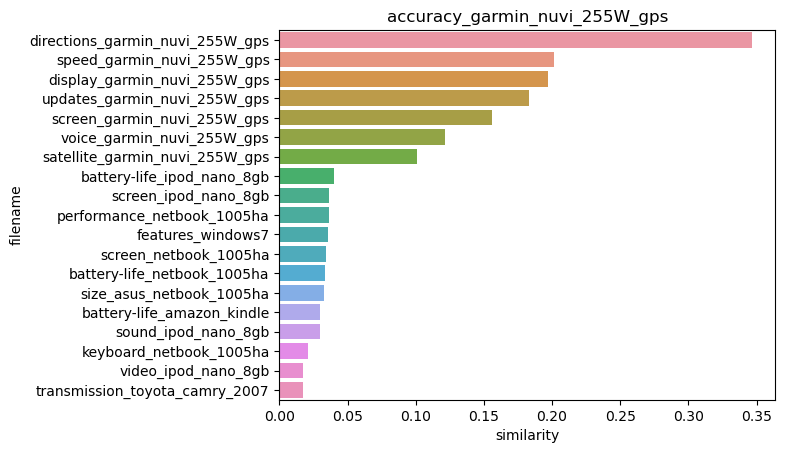

In [62]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# argsort()를 이용하여 앞예제의 첫번째 문서와 타 문서간 유사도가 큰 순으로 정렬한 인덱스 반환하되 자기 자신은 제외. 
sorted_index = similarity_pair.argsort()[:,::-1]
sorted_index = sorted_index[:, 1:]

# 유사도가 큰 순으로 hotel_indexes를 추출하여 재 정렬. 
hotel_sorted_indexes = hotel_indexes[sorted_index.reshape(-1)]

# 유사도가 큰 순으로 유사도 값을 재정렬하되 자기 자신은 제외
hotel_1_sim_value = np.sort(similarity_pair.reshape(-1))[::-1]
hotel_1_sim_value = hotel_1_sim_value[1:]

# 유사도가 큰 순으로 정렬된 Index와 유사도값을 이용하여 파일명과 유사도값을 Seaborn 막대 그래프로 시각화
hotel_1_sim_df = pd.DataFrame()
hotel_1_sim_df['filename'] = document_df.iloc[hotel_sorted_indexes]['filename']
hotel_1_sim_df['similarity'] = hotel_1_sim_value

fig1 = plt.gcf()
sns.barplot(x='similarity', y='filename',data=hotel_1_sim_df)
plt.title(comparison_docname)
# fig1.savefig('p553_hotel.tif', format='tif', dpi=300, bbox_inches='tight')


### 8.9 한글 텍스트 처리- 네이버 영화 평점 감성 분석

In [64]:
from konlpy.tag import Twitter
from konlpy.tag import Okt
from konlpy.tag import Kkma

In [65]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

train_df = pd.read_csv('ratings_train.txt', sep='\t')
train_df.head(3)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [67]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [ ]:
import re

train_df = train_df.fillna(' ')
# 정규 표현식을 이용하여 숫자를 공백으로 변경(정규 표현식으로 \d 는 숫자를 의미함.) 
train_df['document'] = train_df['document'].apply( lambda x : re.sub(r"\d+", " ", x) )

# 테스트 데이터 셋을 로딩하고 동일하게 Null 및 숫자를 공백으로 변환
test_df = pd.read_csv('ratings_test.txt', sep='\t')
test_df = test_df.fillna(' ')
test_df['document'] = test_df['document'].apply( lambda x : re.sub(r"\d+", " ", x) )

# id 칼럼 삭제 수행
train_df.drop('id', axis=1, inplace=True) 
test_df.drop('id', axis=1, inplace=True)

In [71]:
from konlpy.tag import Okt

okt = Okt()
def tw_tokenizer(text):
    # 입력 인자로 들어온 text 를 형태소 단어로 토큰화 하여 list 객체 반환
    tokens_ko = okt.morphs(text)
    return tokens_ko

tw_tokenizer('아버지 가방에 들어가신다.')
tw_tokenizer('머릿결')

['머릿결']

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Twitter 객체의 morphs( ) 객체를 이용한 tokenizer를 사용. ngram_range는 (1,2) 
tfidf_vect = TfidfVectorizer(tokenizer=tw_tokenizer, ngram_range=(1,2), min_df=3, max_df=0.9)
tfidf_vect.fit(train_df['document'])
tfidf_matrix_train = tfidf_vect.transform(train_df['document'])

ValueError: np.nan is an invalid document, expected byte or unicode string.

In [ ]:
# Logistic Regression 을 이용하여 감성 분석 Classification 수행. 
lg_clf = LogisticRegression(random_state=0, solver='liblinear')

# Parameter C 최적화를 위해 GridSearchCV 를 이용. 
params = { 'C': [1 ,3.5, 4.5, 5.5, 10 ] }
grid_cv = GridSearchCV(lg_clf , param_grid=params , cv=3 ,scoring='accuracy', verbose=1 )
grid_cv.fit(tfidf_matrix_train , train_df['label'] )
print(grid_cv.best_params_ , round(grid_cv.best_score_,4))
Fitting 3 folds for each of 5 candidates, totalling 15 fits
{'C': 3.5} 0.8593
from sklearn.metrics import accuracy_score

# 학습 데이터를 적용한 TfidfVectorizer를 이용하여 테스트 데이터를 TF-IDF 값으로 Feature 변환함. 
tfidf_matrix_test = tfidf_vect.transform(test_df['document'])

# classifier 는 GridSearchCV에서 최적 파라미터로 학습된 classifier를 그대로 이용
best_estimator = grid_cv.best_estimator_
preds = best_estimator.predict(tfidf_matrix_test)

print('Logistic Regression 정확도: ',accuracy_score(test_df['label'],preds))
Logistic Regression 정확도:  0.86172
 